# Lateness

- berücksichtigt auch eine negative Abweichung, also wenn ein Job früher fertiggestellt wurde als geplant.

$$
L_j = C_j - d_j
$$


- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**  
- $L_j = 0$: Job ist **pünktlich**  
- $L_j < 0$: Job ist **zu früh** fertig

In [4]:
max_time = 60 * 20 # 20min

In [5]:
import time

In [6]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 11)

In [7]:
import utils.presenter as show
import utils.checker as check

import utils.rolling_planning.init_jobs_times as rp_init
import utils.schedule_deadline as deadline_gen

In [8]:
import utils.scheduling_solver as ssv

In [9]:
df_instance= pd.read_csv("data/00_instance.csv")

df_jssp, df_arrivals = rp_init.init_jobs_with_arrivals(df_instance, 1, u_b_mmax= 0.9)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
185,Job_018,5,M9,76
186,Job_018,6,M5,47
187,Job_018,7,M3,52
188,Job_018,8,M4,90


In [10]:
df_times = deadline_gen.get_times_df(df_jssp, df_arrivals, ssv.schedule_fcfs_with_arrivals, target_service=1, buffer_factor=1)
df_times

,Job,Arrival,Deadline
0,Job_000,0.00,892
1,Job_001,88.05,1239
2,Job_002,152.78,1435
3,Job_003,207.97,1686
4,Job_004,246.61,1134
...,...,...,...
14,Job_014,1190.89,2669
15,Job_015,1197.28,2084
16,Job_016,1198.72,2481
17,Job_017,1324.04,2216


In [11]:
df_times["Arrival"] = np.floor(df_times["Arrival"]).astype(int)
df_times["Deadline"] = np.ceil(df_times["Deadline"]).astype(int)
df_times

,Job,Arrival,Deadline
0,Job_000,0,892
1,Job_001,88,1239
2,Job_002,152,1435
3,Job_003,207,1686
4,Job_004,246,1134
...,...,...,...
14,Job_014,1190,2669
15,Job_015,1197,2084
16,Job_016,1198,2481
17,Job_017,1324,2216


## a) Summe der absoluten Lateness je Job (letze Operation)

$$
\min \sum_{j \in J} \left| C_j - d_j \right|
$$

- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Endzeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\left| C_j - d_j \right|$: absolute Abweichung zur Deadline

**Erklärung:**  
Diese Zielfunktion minimiert die **Summe aller Abweichungen zur Deadline**, unabhängig davon, ob ein Job zu früh oder zu spät fertig wird.  
Sie fördert eine **gleichmäßige, zentrierte Fertigstellung** aller Jobs um ihre Soll-Zeitpunkte (Deadlines).



In [14]:
from ortools.sat.python import cp_model
import pandas as pd

def has_solution(solver, any_var):
    try:
        _ = solver.Value(any_var)
        return True
    except:
        return False

def solve_cp_jssp_sum_absolute_lateness(df_jssp: pd.DataFrame, df_arrivals_deadlines: pd.DataFrame, 
                                        sort_ascending: bool = False, msg: bool = False,
                                        timeLimit: int = 3600, gapRel: float = 0.0) -> pd.DataFrame:
    model = cp_model.CpModel()

    # Sortiere nach Deadline, falls gewünscht
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # Gruppiere Operationen je Job
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = int(row["Operation"])
            m = str(row["Machine"])
            d = int(round(row["Processing Time"]))
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    n = len(jobs)
    horizon = int(df_jssp["Processing Time"].sum() + max(deadline.values()))

    # Variablen definieren
    starts, ends, intervals = {}, {}, {}
    abs_lateness_vars = []

    for j, job in enumerate(jobs):
        seq = all_ops[j]
        for o, (op_id, m, d) in enumerate(seq):
            suffix = f"{j}_{o}"
            start = model.NewIntVar(0, horizon, f"start_{suffix}")
            end = model.NewIntVar(0, horizon, f"end_{suffix}")
            interval = model.NewIntervalVar(start, d, end, f"interval_{suffix}")
            starts[(j, o)] = start
            ends[(j, o)] = end
            intervals[(j, o)] = (interval, m)

    # Lateness-Berechnung und Nebenbedingungen pro Job
    for j, job in enumerate(jobs):
        last_op = len(all_ops[j]) - 1
        job_end = ends[(j, last_op)]

        # Lateness kann positiv (zu spät) oder negativ (zu früh) sein
        lateness = model.NewIntVar(-horizon, horizon, f"lateness_{j}")
        abs_lateness = model.NewIntVar(0, horizon, f"abs_lateness_{j}")

        model.Add(lateness == job_end - deadline[job])
        model.AddAbsEquality(abs_lateness, lateness)

        abs_lateness_vars.append(abs_lateness)

        # Arrival-Bedingung
        model.Add(starts[(j, 0)] >= arrival[job])

        # Technologische Reihenfolge
        for o in range(1, len(all_ops[j])):
            model.Add(starts[(j, o)] >= ends[(j, o - 1)])

    # Maschinenkonflikte (NoOverlap)
    for m in machines:
        machine_intervals = [intervals[(j, o)][0] for (j, o), (interval, mach) in intervals.items() if mach == m]
        model.AddNoOverlap(machine_intervals)

    # Zielfunktion: Summe der absoluten Lateness-Werte
    model.Minimize(sum(abs_lateness_vars))

    # Solver konfigurieren
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = msg
    solver.parameters.relative_gap_limit = gapRel
    solver.parameters.max_time_in_seconds = timeLimit

    # Modell lösen
    status = solver.Solve(model)

    # Ergebnisse extrahieren
    records = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE, cp_model.UNKNOWN]:
        if has_solution(solver, next(iter(starts.values()))):
            for j, job in enumerate(jobs):
                for o, (op_id, m, d) in enumerate(all_ops[j]):
                    st = solver.Value(starts[(j, o)])
                    ed = st + d
                    lateness = ed - deadline[job]
                    records.append({
                        "Job": job,
                        "Operation": op_id,
                        "Arrival": arrival[job],
                        "Deadline": deadline[job],
                        "Machine": m,
                        "Start": st,
                        "Processing Time": d,
                        "End": ed,
                        "Lateness": lateness,
                        "Absolute Lateness": abs(lateness)
                    })

            df_schedule = pd.DataFrame.from_records(records).sort_values(["Start", "Job", "Operation"]).reset_index(drop=True)
        else:
            print("No solution was found within the time limit!")
            df_schedule = pd.DataFrame()
    else:
        df_schedule = pd.DataFrame()

    # Logging
    print(f"\nSolver-Status: {solver.StatusName(status)}")
    if records:
        print(f"Summe Absolute Lateness : {solver.ObjectiveValue()}")
    print(f"Best Objective Bound    : {solver.BestObjectiveBound()}")
    print(f"Laufzeit                : {solver.WallTime():.2f} Sekunden")

    return df_schedule




In [15]:
starting_time = time.time()

# Scheduling
df_plan_sum_l = solve_cp_jssp_sum_absolute_lateness(df_jssp, df_times, msg=False, timeLimit=max_time, gapRel= 0.0)

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan_sum_l


Solver-Status: OPTIMAL
Summe Absolute Lateness : 0.0
Best Objective Bound    : 0.0
Laufzeit                : 0.08 Sekunden

Scheduling-Dauer: 0 Minuten und 0.14 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Absolute Lateness
0,Job_000,0,0,892,M0,0,29,29,-863,863
1,Job_000,1,0,892,M1,29,78,107,-785,785
2,Job_001,0,88,1239,M0,88,43,131,-1108,1108
3,Job_000,2,0,892,M2,107,9,116,-776,776
4,Job_000,3,0,892,M3,116,36,152,-740,740
...,...,...,...,...,...,...,...,...,...,...
185,Job_011,9,944,2292,M8,2218,74,2292,0,0
186,Job_013,9,1185,2305,M7,2280,25,2305,0,0
187,Job_016,9,1198,2481,M4,2448,33,2481,0,0
188,Job_018,9,1429,2648,M7,2603,45,2648,0,0


In [16]:
show.count_column_grouped(df_plan_sum_l, 'Absolute Lateness')

<0            0
0            19
0-30          0
30-60         0
60-120        1
120-240       3
240-480      20
480-720      48
720-1440     99
1440-2880     0
>2880         0
dtype: int32

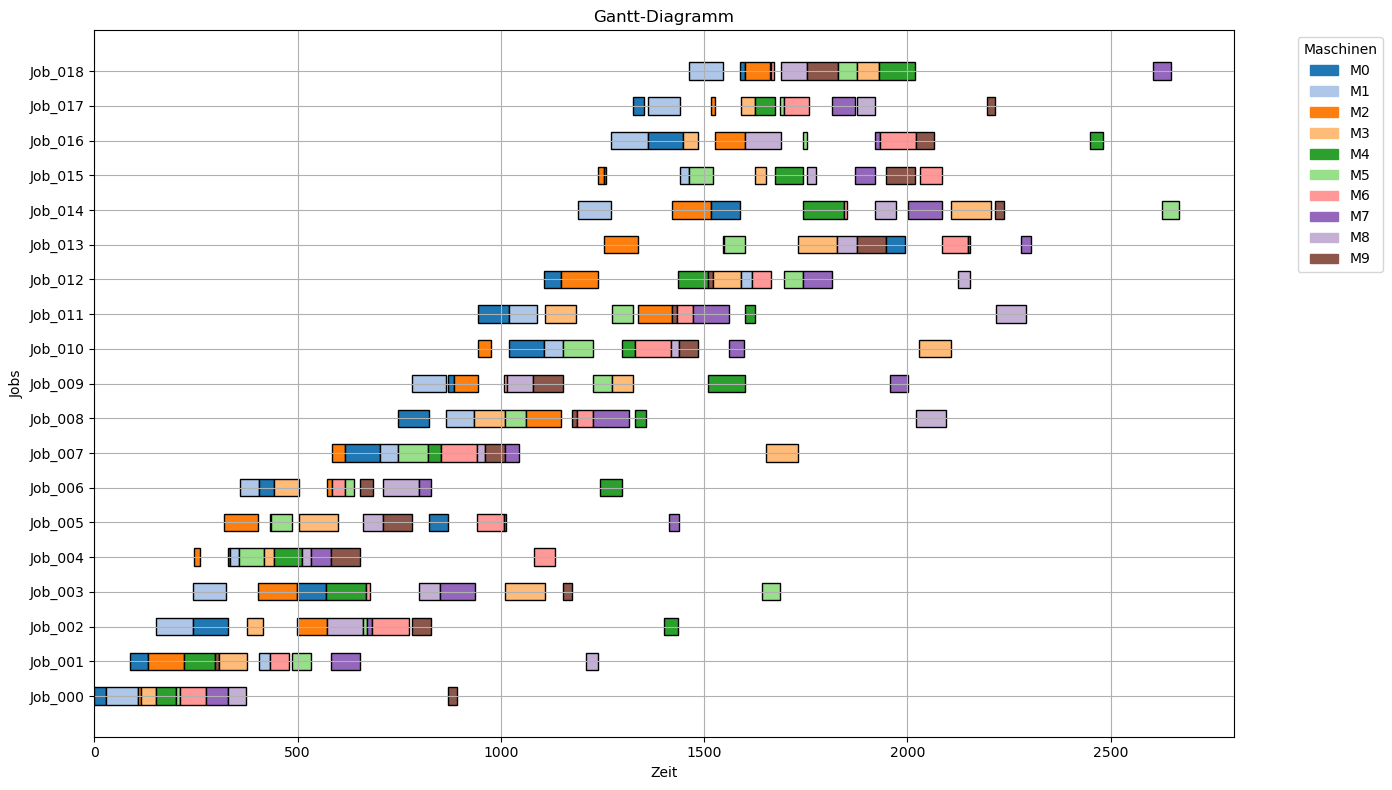

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [17]:
df_plan = df_plan_sum_l

show.plot_gantt_jobs(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

## b) Summe der absoluten Lateness minimieren (je Operation)

$$
\min \sum_{(j,o) \in O} \left| C_{j,o} - d_j \right|
$$

- $O$: Menge aller **Operationen** $(j,o)$, wobei $j$ der Job und $o$ die Operation innerhalb dieses Jobs ist  
- $C_{j,o}$: tatsächliche Endzeit (Completion Time) der Operation $o$ von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\left| C_{j,o} - d_j \right|$: absolute Abweichung der Operation $o$ zur Deadline ihres Jobs  

**Erklärung:**  
Diese Zielfunktion minimiert die **Summe aller Abweichungen** zwischen den Endzeiten *einzelner Operationen* und der Deadline ihres zugehörigen Jobs.  
Dabei werden **Früh- und Spätfertigungen gleichermaßen bestraft**.  
Dies führt zu einer **zentrierten Verteilung aller Operationen** um die Deadline ihres Jobs – ideal für Szenarien, in denen auch frühe Ausführungen unerwünscht sind (z. B. bei Just-in-Time-Produktion).


In [20]:
from ortools.sat.python import cp_model
import pandas as pd

def has_solution(solver, any_var):
    try:
        _ = solver.Value(any_var)
        return True
    except:
        return False

def solve_cp_jssp_sum_absolute_lateness__ops(df_jssp: pd.DataFrame, df_arrivals_deadlines: pd.DataFrame,
                                             sort_ascending: bool = False, msg: bool = False,
                                             timeLimit: int = 3600, gapRel: float = 0.0) -> pd.DataFrame:
    model = cp_model.CpModel()

    # Sortierung (optional)
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # Operationen pro Job
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = int(row["Operation"])
            m = str(row["Machine"])
            d = int(round(row["Processing Time"]))
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    horizon = int(df_jssp["Processing Time"].sum() + max(deadline.values()))

    # Variablen
    starts, ends, intervals = {}, {}, {}
    lateness_vars = {}
    abs_lateness_vars = []

    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            suffix = f"{j}_{o}"
            start = model.NewIntVar(0, horizon, f"start_{suffix}")
            end = model.NewIntVar(0, horizon, f"end_{suffix}")
            interval = model.NewIntervalVar(start, d, end, f"interval_{suffix}")
            starts[(j, o)] = start
            ends[(j, o)] = end
            intervals[(j, o)] = (interval, m)

            lateness = model.NewIntVar(-horizon, horizon, f"lateness_{suffix}")
            abs_lateness = model.NewIntVar(0, horizon, f"abs_lateness_{suffix}")
            model.Add(lateness == end - deadline[job])
            model.AddAbsEquality(abs_lateness, lateness)

            lateness_vars[(j, o)] = lateness
            abs_lateness_vars.append(abs_lateness)

    # Technologische Reihenfolge & Arrival
    for j, job in enumerate(jobs):
        for o in range(1, len(all_ops[j])):
            model.Add(starts[(j, o)] >= ends[(j, o - 1)])
        model.Add(starts[(j, 0)] >= arrival[job])

    # Maschinenkonflikte
    for m in machines:
        machine_intervals = [intervals[(j, o)][0] for (j, o), (interval, mach) in intervals.items() if mach == m]
        model.AddNoOverlap(machine_intervals)

    # Zielfunktion
    model.Minimize(sum(abs_lateness_vars))

    # Solver konfigurieren
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = msg
    solver.parameters.relative_gap_limit = gapRel
    solver.parameters.max_time_in_seconds = timeLimit
    status = solver.Solve(model)

    # Ergebnis extrahieren
    records = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE, cp_model.UNKNOWN]:
        if has_solution(solver, next(iter(starts.values()))):
            for j, job in enumerate(jobs):
                for o, (op_id, m, d) in enumerate(all_ops[j]):
                    st = solver.Value(starts[(j, o)])
                    ed = solver.Value(ends[(j, o)])
                    lateness = solver.Value(lateness_vars[(j, o)])
                    records.append({
                        "Job": job,
                        "Operation": op_id,
                        "Arrival": arrival[job],
                        "Deadline": deadline[job],
                        "Machine": m,
                        "Start": st,
                        "Processing Time": d,
                        "End": ed,
                        "Lateness": lateness,
                        "Absolute Lateness": abs(lateness)
                    })
            df_schedule = pd.DataFrame.from_records(records).sort_values(["Start", "Job", "Operation"]).reset_index(drop=True)
        else:
            print("Keine Lösung innerhalb des Zeitlimits.")
            df_schedule = pd.DataFrame()
    else:
        df_schedule = pd.DataFrame()

    # Logging
    print(f"\nSolver-Status           : {solver.StatusName(status)}")
    if records:
        print(f"Summe Absolute Lateness : {solver.ObjectiveValue()}")
    print(f"Best Objective Bound    : {solver.BestObjectiveBound()}")
    print(f"Laufzeit                : {solver.WallTime():.2f} Sekunden")

    return df_schedule


In [21]:
starting_time = time.time()

# Scheduling
df_plan_sum_l = solve_cp_jssp_sum_absolute_lateness__ops(df_jssp, df_times, msg=False, timeLimit=max_time, gapRel= 0.05)

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan_sum_l


Solver-Status           : FEASIBLE
Summe Absolute Lateness : 31532.0
Best Objective Bound    : 24116.0
Laufzeit                : 180.54 Sekunden

Scheduling-Dauer: 3 Minuten und 0.58 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Absolute Lateness
0,Job_000,0,0,892,M0,691,29,720,-172,172
1,Job_000,1,0,892,M1,720,78,798,-94,94
2,Job_000,2,0,892,M2,798,9,807,-85,85
3,Job_000,3,0,892,M3,807,36,843,-49,49
4,Job_000,4,0,892,M4,843,49,892,0,0
...,...,...,...,...,...,...,...,...,...,...
185,Job_014,7,1190,2669,M3,2795,98,2893,224,224
186,Job_018,9,1429,2648,M7,2795,45,2840,192,192
187,Job_016,9,1198,2481,M4,2814,33,2847,366,366
188,Job_014,8,1190,2669,M9,2893,22,2915,246,246


In [22]:
show.count_column_grouped(df_plan_sum_l, 'Lateness')

<0           86
0             4
0-30         11
30-60        12
60-120       19
120-240      32
240-480      24
480-720       2
720-1440      0
1440-2880     0
>2880         0
dtype: int32

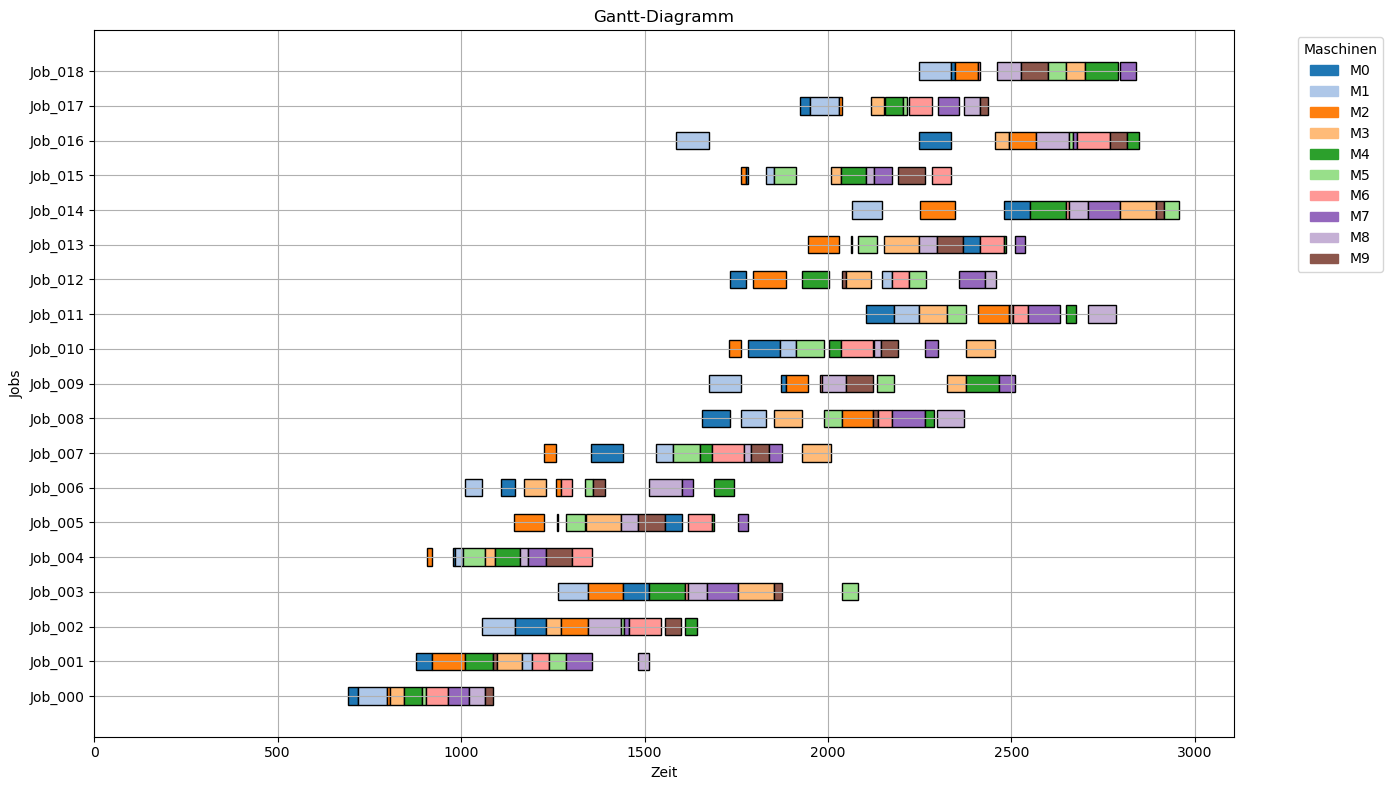

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [23]:
df_plan = df_plan_sum_l

show.plot_gantt_jobs(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

## c) Summe der Lateness minimieren (gewichtet Tardiness und Earliness je Operation)

$$
\min \sum_{(j,o) \in O} \left( 
    w_1 \cdot \max(0, C_{j,o} - d_j) + 
    w_2 \cdot \max(0, d_j - C_{j,o}) 
\right)
$$

- $O$: Menge aller Operationen $(j,o)$  
- $C_{j,o}$: tatsächliche Endzeit der Operation $o$ von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\max(0, C_{j,o} - d_j)$: Tardiness (Verspätung)  
- $\max(0, d_j - C_{j,o})$: Earliness (Frühfertigung)  
- $w_1$: Gewicht für Verspätung 
- $w_2$: Gewicht für Frühfertigung

In [26]:
from ortools.sat.python import cp_model
import pandas as pd

def has_solution(solver, any_var):
    try:
        _ = solver.Value(any_var)
        return True
    except:
        return False

def solve_cp_jssp_weighted_lateness_ops(df_jssp: pd.DataFrame, df_arrivals_deadlines: pd.DataFrame,
                                        w1: float = 5.0, w2: float = 1.0,
                                        sort_ascending: bool = False, msg: bool = False,
                                        timeLimit: int = 3600, gapRel: float = 0.0) -> pd.DataFrame:
    model = cp_model.CpModel()

    # Skalierungsfaktor für Floats → Integer (CP kann keine Floats)
    scale = 10
    w1_scaled = int(w1 * scale)
    w2_scaled = int(w2 * scale)

    # Vorbereitung der Daten
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # Gruppierung der Operationen je Job
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = int(row["Operation"])
            m = str(row["Machine"])
            d = int(round(row["Processing Time"]))
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    horizon = int(df_jssp["Processing Time"].sum() + max(deadline.values()))
    starts, ends, intervals = {}, {}, {}
    weighted_terms = []

    # Variablen und Nebenbedingungen für jede Operation
    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            suffix = f"{j}_{o}"
            start = model.NewIntVar(0, horizon, f"start_{suffix}")
            end = model.NewIntVar(0, horizon, f"end_{suffix}")
            interval = model.NewIntervalVar(start, d, end, f"interval_{suffix}")
            starts[(j, o)] = start
            ends[(j, o)] = end
            intervals[(j, o)] = (interval, m)

            lateness = model.NewIntVar(-horizon, horizon, f"lateness_{j}_{o}")
            earliness = model.NewIntVar(0, horizon, f"earliness_{j}_{o}")
            tardiness = model.NewIntVar(0, horizon, f"tardiness_{j}_{o}")
            model.Add(lateness == end - deadline[job])
            model.AddMaxEquality(tardiness, [lateness, 0])
            model.AddMaxEquality(earliness, [-lateness, 0])

            term = model.NewIntVar(0, horizon * 2 * max(w1_scaled, w2_scaled), f"weighted_{j}_{o}")
            model.Add(term == w1_scaled * tardiness + w2_scaled * earliness)
            weighted_terms.append(term)

    # Technologische Reihenfolge und Arrival-Bedingung
    for j in range(len(jobs)):
        for o in range(1, len(all_ops[j])):
            model.Add(starts[(j, o)] >= ends[(j, o - 1)])
        model.Add(starts[(j, 0)] >= arrival[jobs[j]])

    # Maschinenkonflikte
    for m in machines:
        machine_intervals = [intervals[(j, o)][0] for (j, o), (interval, mach) in intervals.items() if mach == m]
        model.AddNoOverlap(machine_intervals)

    # Zielfunktion
    model.Minimize(sum(weighted_terms))

    # Solver konfigurieren und lösen
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = msg
    solver.parameters.relative_gap_limit = gapRel
    solver.parameters.max_time_in_seconds = timeLimit
    status = solver.Solve(model)

    # Ergebnisse extrahieren
    records = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE, cp_model.UNKNOWN] and has_solution(solver, next(iter(starts.values()))):
        for j, job in enumerate(jobs):
            for o, (op_id, m, d) in enumerate(all_ops[j]):
                st = solver.Value(starts[(j, o)])
                ed = st + d
                lateness = ed - deadline[job]
                tardiness = max(0, lateness)
                earliness = max(0, -lateness)
                weighted = (w1_scaled * tardiness + w2_scaled * earliness) / scale
                records.append({
                    "Job": job,
                    "Operation": op_id,
                    "Arrival": arrival[job],
                    "Deadline": deadline[job],
                    "Machine": m,
                    "Start": st,
                    "Processing Time": d,
                    "End": ed,
                    "Lateness": lateness,
                    "Earliness": earliness,
                    "Tardiness": tardiness,
                    "Weighted Lateness": round(weighted, 2)
                })

        df_schedule = pd.DataFrame.from_records(records).sort_values(["Start", "Job", "Operation"]).reset_index(drop=True)
    else:
        print("No solution found or no feasible value returned.")
        df_schedule = pd.DataFrame()

    print(f"\nSolver-Status         : {solver.StatusName(status)}")
    if not df_schedule.empty:
        print(f"Weighted Objective Val: {solver.ObjectiveValue() / scale:.2f}")
        print(f"Best Objective Bound  : {solver.BestObjectiveBound() / scale:.2f}")
    print(f"Laufzeit              : {solver.WallTime():.2f} Sekunden")

    return df_schedule


In [27]:
starting_time = time.time()

# Scheduling mit gewichteter Lateness
df_plan_weighted_l = solve_cp_jssp_weighted_lateness_ops(df_jssp, df_times,
                                                         w1=7,        # Gewicht für Tardiness
                                                         w2=1,        # Gewicht für Earliness
                                                         msg=False, timeLimit=max_time, gapRel=0.15)
# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan_weighted_l


Solver-Status         : FEASIBLE
Weighted Objective Val: 54866.00
Best Objective Bound  : 41295.00
Laufzeit              : 180.51 Sekunden

Scheduling-Dauer: 3 Minuten und 0.68 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Earliness,Tardiness,Weighted Lateness
0,Job_000,0,0,892,M0,518,29,547,-345,345,0,345.0
1,Job_000,1,0,892,M1,547,78,625,-267,267,0,267.0
2,Job_000,2,0,892,M2,625,9,634,-258,258,0,258.0
3,Job_000,3,0,892,M3,634,36,670,-222,222,0,222.0
4,Job_002,0,152,1435,M1,664,91,755,-680,680,0,680.0
...,...,...,...,...,...,...,...,...,...,...,...,...
185,Job_018,8,1429,2648,M4,2535,90,2625,-23,23,0,23.0
186,Job_014,7,1190,2669,M3,2571,98,2669,0,0,0,0.0
187,Job_018,9,1429,2648,M7,2625,45,2670,22,0,22,154.0
188,Job_014,8,1190,2669,M9,2669,22,2691,22,0,22,154.0


In [28]:
show.count_column_grouped(df_plan_weighted_l, "Tardiness")

<0             0
0            169
0-30          13
30-60          4
60-120         3
120-240        1
240-480        0
480-720        0
720-1440       0
1440-2880      0
>2880          0
dtype: int32

In [29]:
show.count_column_grouped(df_plan_weighted_l, "Earliness")

<0            0
0            26
0-30          8
30-60        10
60-120       16
120-240      35
240-480      59
480-720      35
720-1440      1
1440-2880     0
>2880         0
dtype: int32

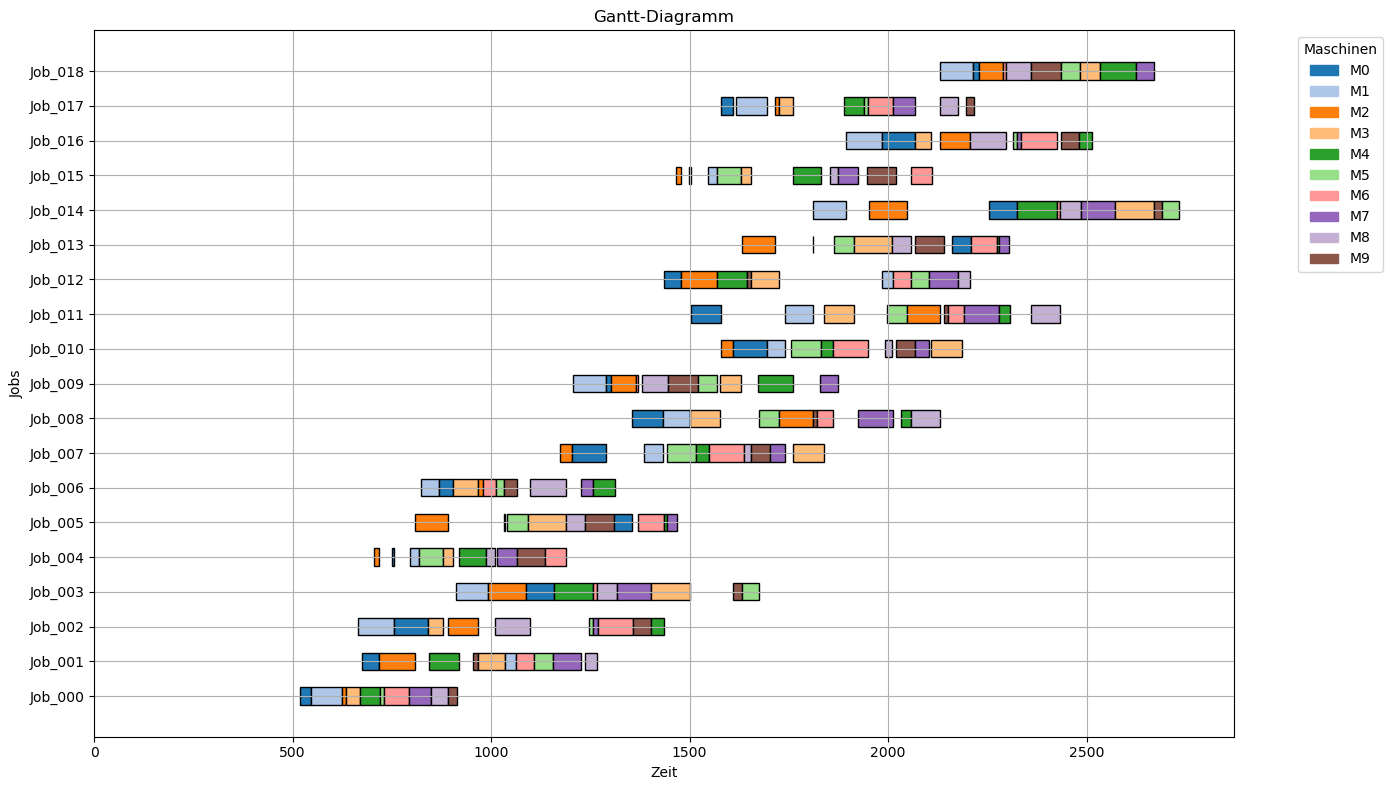

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [30]:
df_plan = df_plan_weighted_l

show.plot_gantt_jobs(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)



$$
\min \left(
    w_1 \cdot \sum_{j \in J} \max(0, C_{j,\text{last}} - d_j)
    \ + \
    w_2 \cdot \sum_{\substack{(j,o) \in O \\ o \ne \text{last}}} \max(0, d_j - C_{j,o})
\right)
$$

* \$J\$: Menge aller Jobs
* \$O\$: Menge aller Operationen \$(j,o)\$
* \$C\_{j,o}\$: Endzeit der Operation \$o\$ von Job \$j\$
* \$d\_j\$: Deadline von Job \$j\$
* \$w\_1\$: Gewicht für Verspätung
* \$w\_2\$: Gewicht für Frühfertigung
* \$\max(0, C\_{j,\text{last}} - d\_j)\$: Tardiness
* \$\max(0, d\_j - C\_{j,o})\$: Earliness für **nicht-letzte** Operationen




In [75]:
from ortools.sat.python import cp_model
import pandas as pd

# Hilfsfunktion zur Prüfung, ob eine Lösung existiert
def has_solution(solver, any_var):
    try:
        _ = solver.Value(any_var)
        return True
    except:
        return False

def solve_cp_jssp_weighted_job_tardiness_and_op_earliness(
    df_jssp: pd.DataFrame,
    df_arrivals_deadlines: pd.DataFrame,
    w1: float = 5.0,                      # Gewicht für Tardiness (Verspätung)
    w2: float = 1.0,                      # Gewicht für Earliness (Frühzeitigkeit)
    sort_ascending: bool = False,
    msg: bool = False,
    timeLimit: int = 3600,
    gapRel: float = 0.0
) -> pd.DataFrame:

    model = cp_model.CpModel()

    # CP-Modell unterstützt nur Integer, daher Skalierung
    scale = 10
    w1_scaled = int(w1 * scale)
    w2_scaled = int(w2 * scale)

    # Daten vorbereiten: Ankunftszeiten, Deadlines, Jobliste
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # Operationen pro Job extrahieren
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = int(row["Operation"])
            m = str(row["Machine"])
            d = int(round(row["Processing Time"]))
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    # Grobe Abschätzung des Planungshorizonts
    horizon = int(df_jssp["Processing Time"].sum() + max(deadline.values()))

    starts, ends, intervals = {}, {}, {}
    weighted_terms = []  # Zielterme

    # Variablen und Intervalle für jede Operation
    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            suffix = f"{j}_{o}"
            start = model.NewIntVar(0, horizon, f"start_{suffix}")
            end = model.NewIntVar(0, horizon, f"end_{suffix}")
            interval = model.NewIntervalVar(start, d, end, f"interval_{suffix}")
            starts[(j, o)] = start
            ends[(j, o)] = end
            intervals[(j, o)] = (interval, m)

    # Zielfunktion vorbereiten
    for j, job in enumerate(jobs):
        last_op_index = len(all_ops[j]) - 1

        # Tardiness (nur letzte Operation)
        job_end = ends[(j, last_op_index)]
        lateness = model.NewIntVar(-horizon, horizon, f"lateness_last_{j}")
        tardiness = model.NewIntVar(0, horizon, f"tardiness_last_{j}")
        model.Add(lateness == job_end - deadline[job])
        model.AddMaxEquality(tardiness, [lateness, 0])
        term_tardiness = model.NewIntVar(0, horizon * w1_scaled, f"term_tardiness_{j}")
        model.Add(term_tardiness == w1_scaled * tardiness)
        weighted_terms.append(term_tardiness)

        # Earliness (für alle außer letzte Operation)
        for o in range(last_op_index):
            ed = ends[(j, o)]
            early_lateness = model.NewIntVar(-horizon, horizon, f"early_lateness_{j}_{o}")
            earliness = model.NewIntVar(0, horizon, f"earliness_{j}_{o}")
            model.Add(early_lateness == ed - deadline[job])
            model.AddMaxEquality(earliness, [-early_lateness, 0])
            term_earliness = model.NewIntVar(0, horizon * w2_scaled, f"term_earliness_{j}_{o}")
            model.Add(term_earliness == w2_scaled * earliness)
            weighted_terms.append(term_earliness)

    # Technologische Reihenfolge und Startzeit nach Ankunft
    for j in range(len(jobs)):
        for o in range(1, len(all_ops[j])):
            model.Add(starts[(j, o)] >= ends[(j, o - 1)])
        model.Add(starts[(j, 0)] >= arrival[jobs[j]])

    # Maschinenbelegung (keine Überlappung)
    for m in machines:
        machine_intervals = [intervals[(j, o)][0] for (j, o), (iv, mach) in intervals.items() if mach == m]
        model.AddNoOverlap(machine_intervals)

    # Zielfunktion: Summe aller gewichteten Lateness-Terme
    model.Minimize(sum(weighted_terms))

    # Solverkonfiguration und Lösung
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = msg
    solver.parameters.relative_gap_limit = gapRel
    solver.parameters.max_time_in_seconds = timeLimit
    status = solver.Solve(model)

    # Ergebnisse extrahieren
    records = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE] and has_solution(solver, next(iter(starts.values()))):
        for j, job in enumerate(jobs):
            for o, (op_id, m, d) in enumerate(all_ops[j]):
                st = solver.Value(starts[(j, o)])
                ed = st + d
    
                # Lateness berechnen
                lateness = ed - deadline[job]
                tardiness = max(0, lateness)
                earliness = max(0, -lateness)
    
                records.append({
                    "Job": job,
                    "Operation": op_id,
                    "Arrival": arrival[job],
                    "Deadline": deadline[job],
                    "Machine": m,
                    "Start": st,
                    "Processing Time": d,
                    "End": ed,
                    "Lateness": lateness,
                    "Tardiness": tardiness,
                    "Earliness": earliness
                })
    
        df_schedule = pd.DataFrame.from_records(records).sort_values(["Start", "Job", "Operation"]).reset_index(drop=True)
    else:
        print("No feasible solution found.")
        df_schedule = pd.DataFrame()
    
    # Statusausgabe
    print(f"\nSolver-Status         : {solver.StatusName(status)}")
    if not df_schedule.empty:
        print(f"Objective Value       : {solver.ObjectiveValue() / scale:.2f}")
    print(f"Best Objective Bound  : {solver.BestObjectiveBound() / scale:.2f}")
    print(f"Laufzeit              : {solver.WallTime():.2f} Sekunden")
    
    return df_schedule


In [ ]:
starting_time = time.time()

# Aufruf der gewichteten Zielfunktion: Tardiness für letzte Operation, Earliness für alle vorherigen
df_plan = solve_cp_jssp_weighted_job_tardiness_and_op_earliness(
    df_jssp, df_times,
    w1=10.0,      # Gewicht für Tardiness (letzte Operation)
    w2=1.0,      # Gewicht für Earliness (alle anderen)
    msg=False,
    timeLimit=600,
    gapRel=0.05
)

ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan


In [ ]:
show.count_column_grouped(df_plan, "Tardiness")

In [ ]:
show.count_column_grouped(df_plan, "Earliness")